### End to end train both networks

In [1]:
from keras.layers import Input, Dense, Activation, Lambda, Dropout, Concatenate, Reshape
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard, Callback
from keras import optimizers
from keras import backend as K

import tensorflow as tf

from keras.regularizers import l2


/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
### Hyperparameters

experiment_id = 0

learning_rate = 0.0001

epochs = [10] #[200, 20000, 10000, 4000]
batch_sizes = [256] #[1024, 1024, 128, 1024]

lambda_1 = 0.1       
lambda_2 = 0.005     

#################

epoch = epochs[experiment_id]
batch_size = batch_sizes[experiment_id]

### Define compresion network

In [3]:
input_data = Input(batch_shape=(batch_size,120), name='input_placeholder')

encoded = Dense(60, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(input_data)
encoded = Dense(30, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(encoded)
encoded = Dense(10, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(encoded)

layer_lowdim = Dense(1, activation='linear', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001), name='lowdim')(encoded)

decoded = Dense(10, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(layer_lowdim)
decoded = Dense(30, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(decoded)
decoded = Dense(60, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(decoded)
decoded = Dense(120, activation='linear', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001), name='reconstructed')(decoded)



- Define similarity metrics

In [4]:
def cos_sim(a_b):
    '''
    a: batch x 120
    b: batch x 120 
    
    output: batch x 1
    '''
    a, b = a_b
    
    norm_a = K.sqrt(K.sum(a ** 2, axis=-1))
    norm_b = K.sqrt(K.sum(b ** 2, axis=-1))
    
    out = K.sum(a * b, axis=-1) / (norm_a * norm_b)
    out = K.reshape(out, [batch_size, 1])
    
    return out

def relative_euc_dist(a_b):
    '''
    a: batch x 120
    b: batch x 120 
    
    output: batch x 1
    '''
    a,b = a_b
    
    norm_diff = K.sqrt(K.sum((a - b)**2, axis=-1))
    norm_a = K.sqrt(K.sum(a ** 2, axis=-1))
    
    out = norm_diff / norm_a
    out = K.reshape(out, [batch_size, 1])

    return out

In [5]:
layer_cossim = Lambda(cos_sim,
                      name='cos_sim')([input_data, decoded])

In [6]:
layer_cossim

<tf.Tensor 'cos_sim/Reshape:0' shape=(256, 1) dtype=float32>

In [7]:
layer_relativeEuc = Lambda(relative_euc_dist, 
                           name='relative_euc_dist')([input_data, decoded])

In [8]:
layer_relativeEuc

<tf.Tensor 'relative_euc_dist/Reshape:0' shape=(256, 1) dtype=float32>

- No need to reshape layer_lowdim

In [9]:
layer_lowdim

<tf.Tensor 'lowdim/BiasAdd:0' shape=(256, 1) dtype=float32>

- Obtain "z"

In [10]:
def funct_concat(tensors):
    return K.concatenate(tensors)

layer_concat = Lambda(funct_concat, name="z")([layer_lowdim, layer_cossim, layer_relativeEuc])

In [11]:
layer_concat

<tf.Tensor 'z/concat:0' shape=(256, 3) dtype=float32>

### Define estimation network

In [12]:
input_est = layer_concat #Input(shape=(3,))(layer_concat)

est_layer = Dense(10, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(input_est)   ####(input_est)
est_layer = Dropout(0.5)(est_layer)
est_output = Dense(4, activation='softmax', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001), name='output_placeholder')(est_layer)


### Build full network

In [13]:
full_network = Model(input=input_data, outputs=est_output)

/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ou..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


In [14]:
full_network.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_placeholder (InputLayer)  (256, 120)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (256, 60)            7260        input_placeholder[0][0]          
__________________________________________________________________________________________________
dense_2 (Dense)                 (256, 30)            1830        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (256, 10)            310         dense_2[0][0]                    
__________________________________________________________________________________________________
lowdim (De

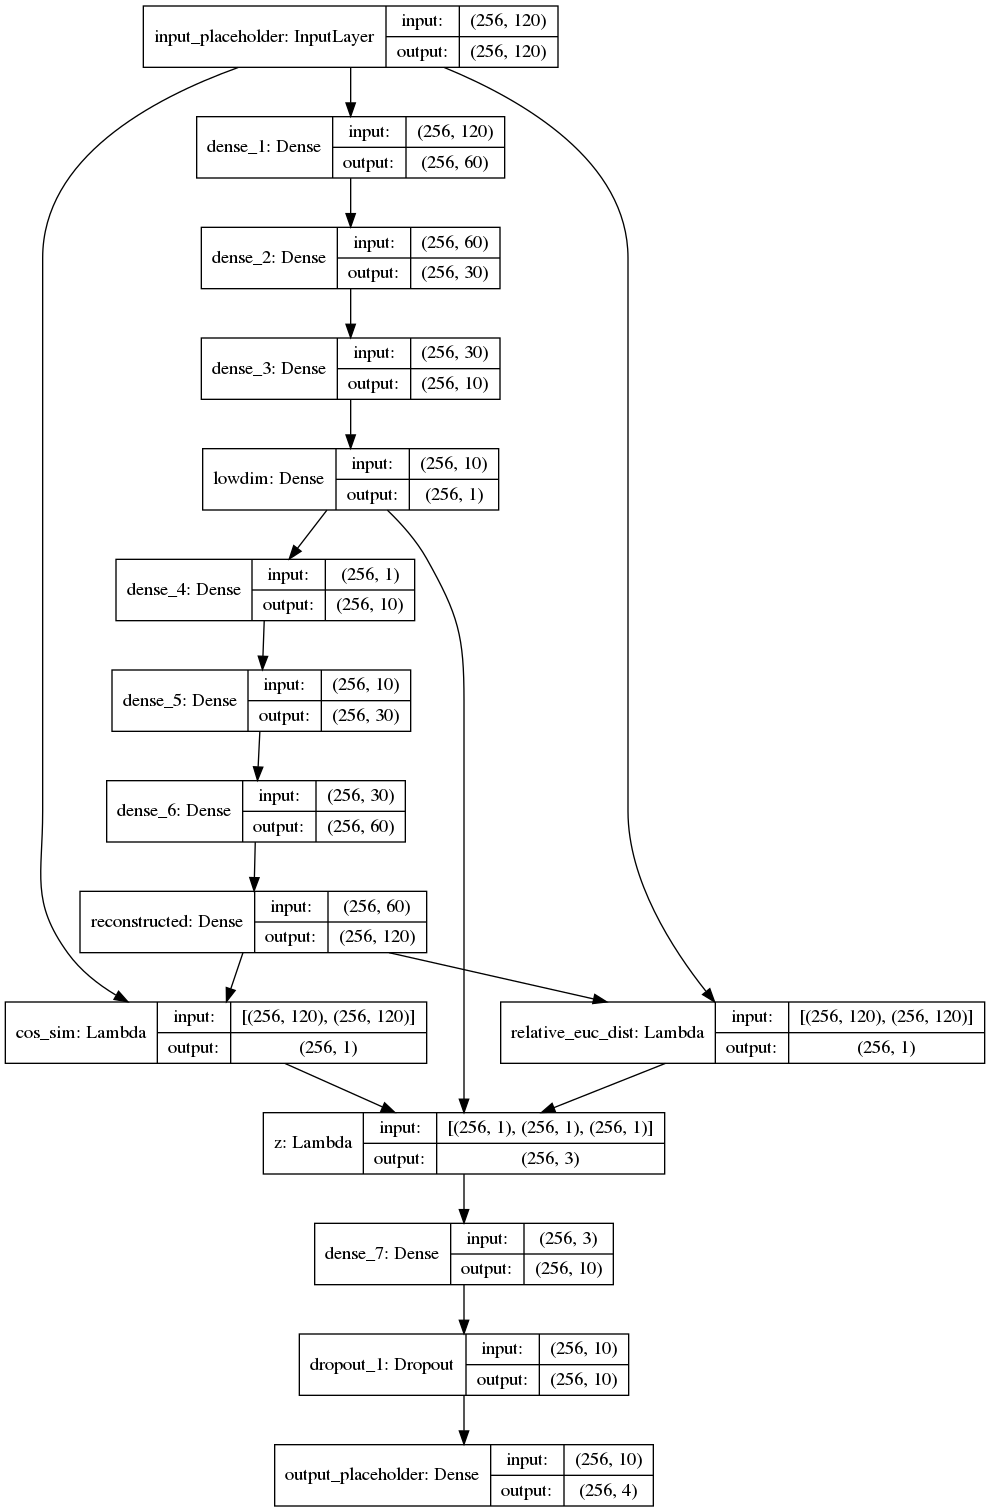

In [15]:
### model visualization
from keras.utils import plot_model


model = full_network

plot_model(model, to_file='model.png', show_layer_names=True, show_shapes=True)

from IPython.display import Image
Image(filename='model.png') 

### Load already saved dataset

In [16]:
import numpy as np

In [17]:
with np.load('kdd99_train_test.npz') as data:
    x_train = data['x_train']     
    x_test = data['x_test']
    x_all = np.concatenate([x_train, x_test], axis=0)

In [18]:
x_all.shape

(494021, 120)

- Get only the normal data

In [19]:
normal_data = x_all[np.where(x_all[:,-1] == 1)]   ##last column is the normal column

In [20]:
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(normal_data, test_size=0.5, random_state=42)

In [21]:
x_train.shape

(48639, 120)

In [22]:
x_test.shape

(48639, 120)

- Assign arbitrary output (assuming first column is normal)

In [23]:
y_train = np.zeros((len(x_train),4))

y_train[:,0] = 1

In [24]:
y_train.shape

(48639, 4)

### GMM parameters

- k: number of clusters (4 for here)
- N: batch size
- d: Dimension of latent vector z (3 here)

- gamma ($\gamma$) : membership predictions (softmax output of estimation net) [$N \times K$]
- phi ($\phi$): gaussian probabilities [$K$]
- mu ($\mu$): gaussian means [$K \times d$]
- sigma ($\Sigma$): gaussian covariances [$K \times d \times d$]

In [25]:
k = 4 
N = batch_size 
d = int(layer_concat.get_shape()[1])

In [26]:
tf_sess = K.get_session()

- GMM parameters init

In [27]:
sigma_init = np.repeat([np.eye(d, dtype=np.float32)],k, axis=0)

In [28]:
sigma_init

array([[[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]],

       [[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]],

       [[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]],

       [[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]], dtype=float32)

In [29]:
phi = tf.get_variable("phi",
                      shape=(k),
                      dtype=tf.float32,
                      initializer=tf.zeros_initializer(),
                      trainable=False)

mu = tf.get_variable("mu",
                      shape=(k,d),
                      dtype=tf.float32,
                      initializer=tf.zeros_initializer(), 
                      trainable=False)

sigma = tf.get_variable("sigma",
                      shape=(k,d,d),
                      dtype=tf.float32,
                      initializer=tf.constant_initializer(sigma_init), ###tf.ones_initializer(),
                      trainable=False)

In [30]:
def printGmmParams():
    print("---shapes---")
    print("phi:\n",phi.shape)
    print("mu:\n",mu.shape)
    print("sigma:\n",sigma.shape)
    
    print("")
    
    print("---values---")
    print("phi:\n",K.eval(phi))
    print("mu:\n",K.eval(mu))
    print("sigma:\n",K.eval(sigma))

In [31]:
printGmmParams()

---shapes---
phi:
 (4,)
mu:
 (4, 3)
sigma:
 (4, 3, 3)

---values---
phi:
 [0. 0. 0. 0.]
mu:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
sigma:
 [[[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]

 [[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]

 [[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]

 [[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]]


### !!! problem:

- When I try to reach those array slices, I get uninitialized values:

In [32]:
print(K.eval(sigma[0]))

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


### Total loss calculation

In [33]:
isVerbose = True

In [34]:
### (for the first time run of the totalLoss function)

choices = np.random.choice(len(x_train), size=batch_size, replace=False)

batch_x_train = x_train[choices]
batch_y_train = y_train[choices]

batch_train = (batch_x_train, batch_y_train)

- Define energy function

In [35]:
def computeEnergy(z_i):
    """
    compute E(z_i) in loss function
    """
    
    inside_sum = 0
    for cluster in range(k):
        diff = z_i - mu[cluster]   ### (1,3)
        diff_t = tf.reshape(diff, (-1,1)) #diff.reshape(-1,1)   ### (3,1)

        sigma_inv = tf.linalg.inv(sigma[cluster]) ### (3,3)
        
        exp_term = tf.exp(-0.5 * tf.matmul(diff * sigma_inv, diff_t))    ### (1,1)
        denom = tf.sqrt(tf.linalg.det(2 * np.pi * sigma[cluster]))

        inside_sum += phi[cluster] * (exp_term / denom)
        
    inside_sum += 1e-6    ### for numerical stability
                
    global isVerbose
    if isVerbose:
        print("---computeEnergy---")
        print("---shapes:")
        print("diff:",diff.shape)
        print("diff_t:",diff_t.shape)
        print("sigma_inv:",sigma_inv.shape)
        print("exp_term:", exp_term.shape)
        print("denom:", denom.shape)
        print("inside_sum:", inside_sum.shape)
        print("---values:")
        print("diff:\n",diff)
        print("diff_t:\n",diff_t)
        print("sigma_inv:\n",sigma_inv)
        print("exp_term:\n", exp_term)
        print("denom:\n", denom)
        print("inside_sum:\n", inside_sum)
        print("")
        
        isVerbose = False

    return -tf.log(inside_sum)

- Define total loss

In [36]:
def totalLoss(yTrue, yPred):
    ### autoencoder loss
    autoenc_loss = tf.sqrt((input_data - decoded)**2)
    #autoenc_loss /= batch_size
    autoenc_loss = tf.reduce_mean(autoenc_loss)
    
    ### obtain z for current batch
    global batch_train
    z = K.function([input_data], [layer_concat])([batch_train[0]])[0]
    
    print("z shape:", z.shape)
    
    ### sample energy
    sample_en = 0
    for z_i in z:
        sample_en += computeEnergy(z_i)
    
    sample_en *= lambda_1
    #sample_en /= batch_size    
    sample_en = tf.reduce_mean(sample_en)
    
    ### diagonal regularization
    #global sigma
    
    p = 0
    for cluster in range(k):
        for dim in range(d):
            sigma_val = K.eval(sigma[cluster, dim, dim])
            p += (1 / sigma_val)
    p += lambda_2

    total_loss = autoenc_loss + sample_en + p
    
    ### print
    global isVerbose
    if isVerbose:
        print("---totalLoss---")
        print("autoenc_loss", type(autoenc_loss))
        print("sample_en", sample_en)
        print("p", p)

    return total_loss    

- Calculate GMM parameters after each batch

In [37]:
class CallbackComputeGMM(Callback):
    def on_batch_end(self, batch, logs={}): 
        
        ### access global batch data, obtain predictions
        #global batch_train
    
        gamma = tf.constant(full_network.predict(batch_train[0], batch_size=batch_size))
    
        
        ### get latent vector z for current batch
        z = layer_concat #K.function([input_data], [layer_concat])([batch_train[0]])[0]
        
        
        ############# calculate gmm parameters
        #global phi, mu, sigma
        
        #### phi
        update_phi = phi.assign(tf.reduce_sum(gamma, axis=0) / batch_size)
        
        ### mu
        for cluster in range(k):
            ### get the corresponding column of predictions
            #gamma_cluster = gamma[:,cluster].reshape(-1,1)    ### (N x 1)
            gamma_cluster = tf.reshape(gamma[:,cluster], (-1,1))    ### (N x 1)

            
            ### duplicate column d times
            #gamma_cluster = np.tile(gamma_cluster, (1,d))   ### (N x d)
            gamma_cluster_tiled = tf.tile(gamma_cluster, (1,d))   ### (N x d)


            ### sum over all batch and divide
            matmul = tf.matmul(gamma_cluster_tile,z)
            update_mu = mu[cluster].assign( tf.reduce_sum(matmul, axis=0) / tf.reduce_sum(gamma[:,cluster], axis = 0))   ### d dim for each cluster

        
        ### sigma
        for cluster in range(k):
            sum_nom = tf.zeros((d,d))

            ### for each sample in batch, accumulate upper part
            for i in range(batch_size):
                diff = z[i] - mu[cluster]
                diff_t = tf.reshape(diff, (-1,1))

                sum_nom += gamma[i, cluster] * (diff * diff_t)

            ### collect lower part
            sum_denom = tf.reduce_sum(gamma[:,cluster], axis = 0)

            update_sigma = sigma[cluster].assign(sum_nom / sum_denom)
        
        ### run updates??
        update_phi.eval(session=tf_sess)
        update_mu.eval(session=tf_sess)
        update_sigma.eval(session=tf_sess)
        
                                           
                                           
        return

- Compile model

In [38]:
compute_gmm = CallbackComputeGMM()

In [39]:
adam = optimizers.adam(lr=learning_rate, clipnorm=1., clipvalue=0.5) 

full_network.compile(optimizer=adam, loss=totalLoss) 

z shape: (256, 3)
---computeEnergy---
---shapes:
diff: (3,)
diff_t: (3, 1)
sigma_inv: (3, 3)
exp_term: (3, 1)
denom: ()
inside_sum: (3, 1)
---values:
diff:
 Tensor("loss/output_placeholder_loss/sub_4:0", shape=(3,), dtype=float32)
diff_t:
 Tensor("loss/output_placeholder_loss/Reshape_3:0", shape=(3, 1), dtype=float32)
sigma_inv:
 Tensor("loss/output_placeholder_loss/MatrixInverse_3:0", shape=(3, 3), dtype=float32)
exp_term:
 Tensor("loss/output_placeholder_loss/Exp_3:0", shape=(3, 1), dtype=float32)
denom:
 Tensor("loss/output_placeholder_loss/Sqrt_4:0", shape=(), dtype=float32)
inside_sum:
 Tensor("loss/output_placeholder_loss/add_4:0", shape=(3, 1), dtype=float32)



/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide


In [40]:
### Tensorboard
from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d_%H:%M")
print(timestamp, "")

tensorboard = TensorBoard(log_dir='./.logs/compNet+estNet_kdd99/{}'.format(timestamp), 
                            histogram_freq=0, 
                            write_graph=True, 
                            write_grads=True, 
                            write_images=True, 
                            embeddings_freq=0, 
                            embeddings_layer_names=None, 
                            embeddings_metadata=None)

2018-05-24_17:00 
Instructions for updating:
Use the retry module or similar alternatives.


- Training in batches

In [41]:
def batchGenerator():
    '''
    return: number of batch_size examples in each run
    '''

    global batch_train
    
    while True:
        choices = np.random.choice(len(x_train), size=batch_size, replace=False)
        
        batch_x_train = x_train[choices]
        batch_y_train = y_train[choices]
        
        batch_train = (batch_x_train, batch_y_train)
        
        
        yield batch_train 

In [42]:
steps_per_epoch = int(np.ceil(x_train.shape[0] / batch_size))

history = full_network.fit_generator(batchGenerator(),
                           epochs = 10, ##epoch,
                           steps_per_epoch = steps_per_epoch,
                           callbacks = [tensorboard, compute_gmm],
                           verbose = 1)

Epoch 1/10


InvalidArgumentError: Input is not invertible.
	 [[Node: loss/output_placeholder_loss/MatrixInverse = MatrixInverse[T=DT_FLOAT, adjoint=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](loss/output_placeholder_loss/strided_slice_1)]]
	 [[Node: loss/add_19/_221 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2301_loss/add_19", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'loss/output_placeholder_loss/MatrixInverse', defined at:
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/ioloop.py", line 759, in _run_callback
    ret = callback()
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2909, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-39-f34b16094073>", line 3, in <module>
    full_network.compile(optimizer=adam, loss=totalLoss)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/training.py", line 830, in compile
    sample_weight, mask)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/training.py", line 429, in weighted
    score_array = fn(y_true, y_pred)
  File "<ipython-input-36-1657e452a4f9>", line 16, in totalLoss
    sample_en += computeEnergy(z_i)
  File "<ipython-input-35-75f8c29ac0fa>", line 11, in computeEnergy
    sigma_inv = tf.linalg.inv(sigma[cluster]) ### (3,3)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 1046, in matrix_inverse
    "MatrixInverse", input=input, adjoint=adjoint, name=name)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Input is not invertible.
	 [[Node: loss/output_placeholder_loss/MatrixInverse = MatrixInverse[T=DT_FLOAT, adjoint=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](loss/output_placeholder_loss/strided_slice_1)]]
	 [[Node: loss/add_19/_221 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2301_loss/add_19", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [ ]:
printGmmParams()